In [1]:
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.algorithms.preprocessing.distributional_repair import DistributionalRepair
# from aif360.algorithms.preprocessing.pointwise_repair import PointwiseRepair

from aif360.datasets import AdultDataset, CompasDataset
import numpy as np
import pandas as pd
import ot
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import time

C:\Users\01joh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
def load_adult_dataset(s,u,x,y):
    def custom_preprocessing(df):
        pd.set_option('future.no_silent_downcasting', True)
        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        df['race'] = df['race'].apply(lambda x: group_race(x))

        # Encode 'sex' column as numerical values
        df['sex'] = df['sex'].map({'Female': 0.0, 'Male': 1.0})

        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value=0, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)
        # 1 if education-num is greater than 9, 0 otherwise
        df['college_educated'] = (df['education-num'] > 9).astype(int)

        #drop nan columns
        df = df.dropna()

        return df

    adult = AdultDataset(
        label_name=y,
        favorable_classes=[1,1],
        protected_attribute_names=[s],
        privileged_classes=[[1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=[s]+[u]+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        features_to_drop=[],
        metadata={}
    )
    return adult

def load_compas_dataset(s,u,x,y):
    def custom_preprocessing(df):
        #print the length of the dataframe
        # Convert 'c_charge_degree' to numeric values
        charge_degree_map = {'M': 0, 'F': 1}  # Map 'M' to 0 and 'F' to 1
        df['c_charge_degree'] = df['c_charge_degree'].map(charge_degree_map)

        # Map 'Caucasian' to 1 and all other values to 0
        df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

        df['sex'] = df['sex'].apply(lambda x:1 if x == "Female" else 0)
        return df

    compas = CompasDataset(
        label_name=y,
        favorable_classes=[1,1],
        protected_attribute_names=[s],
        privileged_classes=[[1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=[s]+[u]+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,

        metadata={}
    )

    return compas


In [3]:
def _eval_kld(x_0, x_1):
    support = np.linspace(np.min([np.min(x_0), np.min(x_1)]), np.max([np.max(x_0), np.max(x_1)]), 500).reshape(-1,1)
    kde_0 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_0.reshape(-1,1))
    pmf_0 = np.exp(kde_0.score_samples(support)) 
    #add a small value to avoid division by zero
    pmf_0 += 1e-10
    kde_1 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_1.reshape(-1,1))
    pmf_1 = np.exp(kde_1.score_samples(support))
    pmf_1 += 1e-10
    return - np.sum(pmf_0 * np.log(pmf_1 / pmf_0))

def eval_kld(x, s, u, order=[0,1]):
    tot_kld = 0.0
    for u_val, u_count in u.value_counts().items():
        mask_0 = np.asarray((u == u_val) & (s == 0))
        mask_1 = np.asarray((u == u_val) & (s == 1))
        if (np.sum(mask_0) == 0) or (np.sum(mask_1) == 0):
            continue
        tmp = _eval_kld(x[mask_0].values, x[mask_1].values)
        if np.isnan(tmp):
            continue
        tot_kld += tmp * u_count / len(u)
    return tot_kld

In [4]:
n_R = 10000 # number of points in the research dataset
n_q = 250 # number of supports under the estimated pdfs

s = 'sex'
u = 'college_educated'
x = ['age','education-num','hours-per-week']
y = 'Income Binary'

continuous_features = ['age','hours-per-week']
# continuous_features = ['age','hours-per-week','education-num']

data = load_adult_dataset(s,u,x,y)
data_R, data_A = data.split([n_R], shuffle=False)

In [5]:
dataset_tests = [
    {'data_loader': load_compas_dataset,
    'dataset_name':'COMPAS',
    's':'race',
    'u':'c_charge_degree',
    'x':['age','priors_count','decile_score'],
    'y':'is_recid',
    'n_R': 5000,
    'n_A':0,
    'n_q': 250,
    'continuous_features' : ['age'],
    'plot_ignored_features': [],
    'results': {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [], 'runtime':[]}
    },
    {'data_loader': load_compas_dataset,
    'dataset_name':'COMPAS',
    's':'sex',
    'u':'c_charge_degree',
    'x':['age','priors_count','decile_score'],
    'y':'is_recid',
    'n_R': 5000,
    'n_A':0,
    'n_q': 250,
    'continuous_features' : ['age'],
    'plot_ignored_features': [],
    'results': {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [],'runtime':[]}
    },
    {'data_loader': load_adult_dataset,
    'dataset_name':'Adult',
    's':'sex',
    'u':'college_educated',
    'x':['age','education-num','hours-per-week'],
    'y':'Income Binary',
    'n_R': 10000,
    'n_A':0,
    'n_q': 250,
    'continuous_features' : ['age','hours-per-week'],
    'plot_ignored_features': ['education-num'],
    'results': {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [],'runtime':[]}
    },
    {'data_loader': load_adult_dataset,
    'dataset_name':'Adult',
    's':'race',
    'u':'college_educated',
    'x':['age','education-num','hours-per-week'],
    'y':'Income Binary',
    'n_R': 10000,
    'n_A':0,
    'n_q': 250,
    'continuous_features' : ['age','hours-per-week'],
    'plot_ignored_features': ['education-num'],
    'results': {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [],'runtime':[]}
    },
]

In [6]:
trials = 20

with tqdm(total=len(dataset_tests) * trials, desc="Progress") as pbar:
    for t in dataset_tests:
        for i in range(trials):
            data = t['data_loader'](t['s'], t['u'], t['x'], t['y'])
            data_R, data_A = data.split([t['n_R']], shuffle=True)
            t['n_A'] = len(data_A.convert_to_dataframe()[0])
            if len(data_A.convert_to_dataframe()[0]) == 0:
                print("There are no samples in the archived dataset. Skipping this trial.")
            d = DistributionalRepair(t['s'], t['u'], t['x'], t['y'], t['continuous_features'], t['n_q'])
            runtimes={}
            t0 = time.perf_counter()
            d.fit(data_R)
            t1 = time.perf_counter()
            dataset_R_repaired = d.transform(data_R)
            t2 = time.perf_counter()
            dataset_A_repaired = d.transform(data_A)
            t3 = time.perf_counter()
            runtimes['fit'] = t1 - t0
            runtimes['transform_R'] = t2 - t1
            runtimes['transform_A'] = t3 - t2
            t['results']['runtime'].append(runtimes)
            # dataset_R_repaired, dataset_A_repaired = d.fit_transform(data_R, data_A)
            tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][t['x']]
            tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][t['x']]
            feats = [f for f in t['x'] if f not in t['plot_ignored_features']]
            kld_x_R = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_R = np.zeros(shape=(len(feats), 2))
            kld_x_A = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_A = np.zeros(shape=(len(feats), 2))
            pos = np.arange(len(feats))
            for i, feat in enumerate(feats):
                kld_x_R[i, 0] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_R[i, 1] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_A[i, 0] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_A[i, 1] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
                kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
            t['results']['kld_x_R'].append(kld_x_R)
            t['results']['kld_x_tilde_R'].append(kld_x_tilde_R)
            t['results']['kld_x_A'].append(kld_x_A)
            t['results']['kld_x_tilde_A'].append(kld_x_tilde_A)
            pbar.update(1)  # Update the progress bar after each trial

Progress: 100%|██████████| 80/80 [16:52<00:00, 12.65s/it]


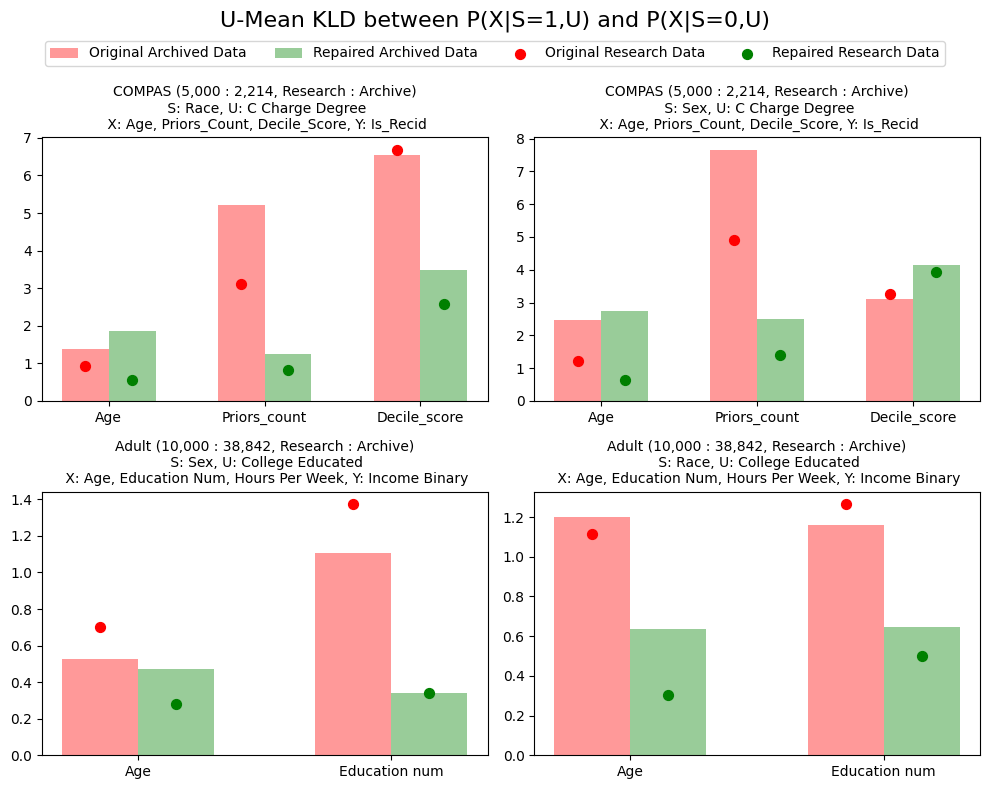

In [25]:
fig, axs = plt.subplots(nrows=(len(dataset_tests) + 1) // 2, ncols=2, figsize=(10, 4*((len(dataset_tests) + 1) // 2)))
axs = axs.flatten()  # Flatten the axs array for easier indexing

handles = []  # Create empty handles list for the legend
for i, t in enumerate(dataset_tests):
    ax = axs[i]
    bar_width = 0.3
    original_color = 'red'
    repaired_color = 'green'
    kld_x_A_mean = np.mean(t['results']['kld_x_A'], axis=0)[:, 0]
    kld_x_tilde_A_mean = np.mean(t['results']['kld_x_tilde_A'], axis=0)[:, 0]
    kld_x_R_mean = np.mean(t['results']['kld_x_R'], axis=0)[:, 0]
    kld_x_tilde_R_mean = np.mean(t['results']['kld_x_tilde_R'], axis=0)[:, 0]
    pos = np.arange(len(kld_x_A_mean))
    original_bars = ax.bar(x=pos - bar_width/2, height=kld_x_A_mean, width=bar_width, alpha=0.4, color=original_color)
    repaired_bars = ax.bar(x=pos + bar_width/2, height=kld_x_tilde_A_mean, width=bar_width, alpha=0.4, color=repaired_color)
    original_scatter = ax.scatter(x=pos - bar_width/2, y=kld_x_R_mean, color=original_color, marker='o', s=50)
    repaired_scatter = ax.scatter(x=pos + bar_width/2, y=kld_x_tilde_R_mean, color=repaired_color, marker='o', s=50)
    x_labels = [x.replace('-', ' ').capitalize() for x in t['x']]
    ax.set_xticks(pos)
    ax.set_xticklabels(x_labels[:len(pos)])  # Slice the labels to match the number of tick locations
    ax.set_title(f"{t['dataset_name']} ({t['n_R']:,} : {t['n_A']:,}, Research : Archive)\n S: {t['s'].title()}, U: {t['u'].replace('_', ' ').title()}\n X: {', '.join([x.replace('-', ' ').title() for x in t['x'] if x])}, Y: {t['y'].replace(' ', ' ').title()}",fontsize=10)
    
    if i == 0:
        handles.extend([original_bars, repaired_bars, original_scatter, repaired_scatter])
        labels = ['Original Archived Data', 'Repaired Archived Data', 'Original Research Data', 'Repaired Research Data']

# Remove any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
fig.suptitle("U-Mean KLD between P(X|S=1,U) and P(X|S=0,U)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

In [26]:
n_R_tests = []

base_config = {
    'data_loader': load_adult_dataset,
    'dataset_name': 'Adult',
    's': 'sex',
    'u': 'college_educated',
    'x': ['age', 'education-num', 'hours-per-week'],
    'y': 'Income Binary',
    'n_A': 0,
    'n_q': 250,
    'continuous_features': ['age', 'hours-per-week'],
    'plot_ignored_features': ['education-num'],
}

for n_R in range(1000, 15000, 2000):
    config = base_config.copy()
    config['n_R'] = n_R
    config['results'] = {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [], 'runtime': []}
    n_R_tests.append(config)

In [27]:
trials = 20

with tqdm(total=len(n_R_tests) * trials, desc="Progress") as pbar:
    for t in n_R_tests:
        for i in range(trials):
            data = t['data_loader'](t['s'], t['u'], t['x'], t['y'])
            data_R, data_A = data.split([t['n_R']], shuffle=True)
            t['n_A'] = len(data_A.convert_to_dataframe()[0])
            if len(data_A.convert_to_dataframe()[0]) == 0:
                print("There are no samples in the archived dataset. Skipping this trial.")
            d = DistributionalRepair(t['s'], t['u'], t['x'], t['y'], t['continuous_features'], t['n_q'])
            runtimes={}
            t0 = time.perf_counter()
            d.fit(data_R)
            t1 = time.perf_counter()
            dataset_R_repaired = d.transform(data_R)
            t2 = time.perf_counter()
            dataset_A_repaired = d.transform(data_A)
            t3 = time.perf_counter()
            runtimes['fit'] = t1 - t0
            runtimes['transform_R'] = t2 - t1
            runtimes['transform_A'] = t3 - t2
            t['results']['runtime'].append(runtimes)
            # dataset_R_repaired, dataset_A_repaired = d.fit_transform(data_R, data_A)
            tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][t['x']]
            tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][t['x']]
            feats = [f for f in t['x'] if f not in t['plot_ignored_features']]
            kld_x_R = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_R = np.zeros(shape=(len(feats), 2))
            kld_x_A = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_A = np.zeros(shape=(len(feats), 2))
            pos = np.arange(len(feats))
            for i, feat in enumerate(feats):
                kld_x_R[i, 0] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_R[i, 1] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_A[i, 0] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_A[i, 1] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
                kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
            t['results']['kld_x_R'].append(kld_x_R)
            t['results']['kld_x_tilde_R'].append(kld_x_tilde_R)
            t['results']['kld_x_A'].append(kld_x_A)
            t['results']['kld_x_tilde_A'].append(kld_x_tilde_A)
            pbar.update(1)  # Update the progress bar after each trial

Progress:   0%|          | 0/140 [00:00<?, ?it/s]

Progress: 100%|██████████| 140/140 [52:38<00:00, 22.56s/it]


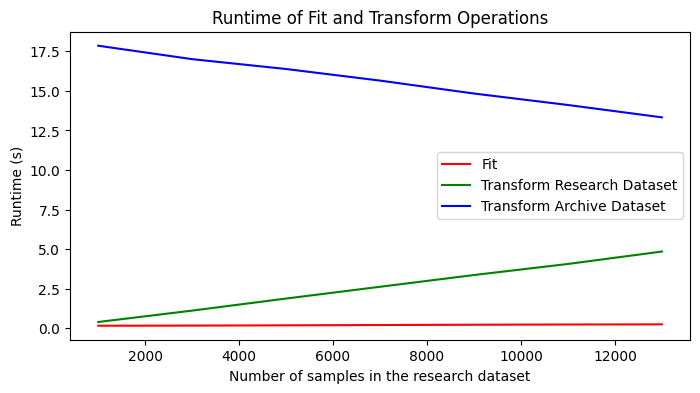

In [28]:
feats = [f for f in t['x'] if f not in t['plot_ignored_features']]

runtimes_fit = []
runtimes_transform_R = []
runtimes_transform_A = []

for t in n_R_tests:
    runtimes_fit.append(np.mean([r['fit'] for r in t['results']['runtime']]))
    runtimes_transform_R.append(np.mean([r['transform_R'] for r in t['results']['runtime']]))
    runtimes_transform_A.append(np.mean([r['transform_A'] for r in t['results']['runtime']]))

#plot runtimes across values of n_R
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot([t['n_R'] for t in n_R_tests], runtimes_fit, label='Fit', color='red')
ax.plot([t['n_R'] for t in n_R_tests], runtimes_transform_R, label='Transform Research Dataset', color='green')
ax.plot([t['n_R'] for t in n_R_tests], runtimes_transform_A, label='Transform Archive Dataset', color='blue')
ax.set_xlabel('Number of samples in the research dataset')
ax.set_ylabel('Runtime (s)')
ax.set_title('Runtime of Fit and Transform Operations')
ax.legend()
plt.show()

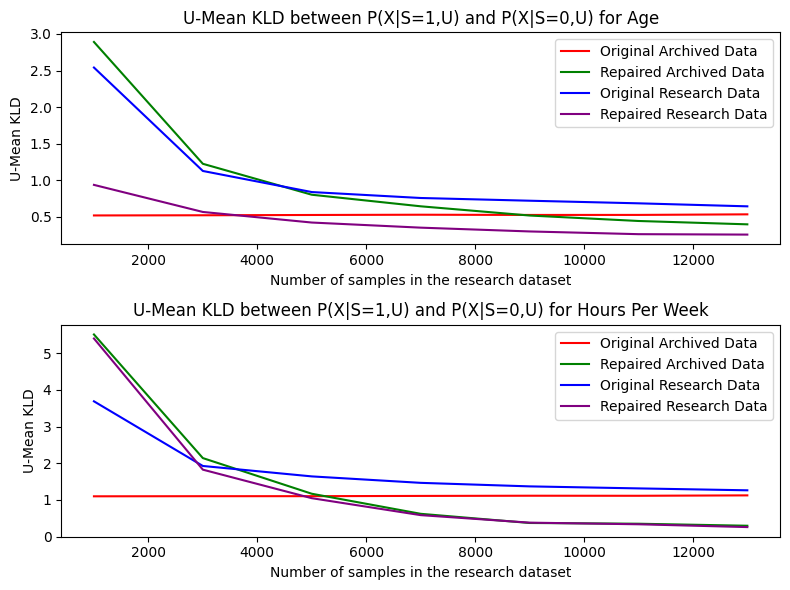

In [29]:
feats = [f for f in t['x'] if f not in t['plot_ignored_features']]
fig, axs = plt.subplots(len(feats), 1, figsize=(8, 6))

for i, f in enumerate(feats):
    kld_x_A_mean_scores = []
    kld_x_tilde_A_mean_scores = []
    kld_x_R_mean_scores = []
    kld_x_tilde_R_mean_scores = []
    
    for t in n_R_tests:
        kld_x_A_mean_scores.append(np.mean(t['results']['kld_x_A'], axis=0)[feats.index(f), 0])
        kld_x_tilde_A_mean_scores.append(np.mean(t['results']['kld_x_tilde_A'], axis=0)[feats.index(f), 0])
        kld_x_R_mean_scores.append(np.mean(t['results']['kld_x_R'], axis=0)[feats.index(f), 0])
        kld_x_tilde_R_mean_scores.append(np.mean(t['results']['kld_x_tilde_R'], axis=0)[feats.index(f), 0])
        
    axs[i].plot([t['n_R'] for t in n_R_tests], kld_x_A_mean_scores, label='Original Archived Data', color='red')
    axs[i].plot([t['n_R'] for t in n_R_tests], kld_x_tilde_A_mean_scores, label='Repaired Archived Data', color='green')
    axs[i].plot([t['n_R'] for t in n_R_tests], kld_x_R_mean_scores, label='Original Research Data', color='blue')
    axs[i].plot([t['n_R'] for t in n_R_tests], kld_x_tilde_R_mean_scores, label='Repaired Research Data', color='purple')
    
    axs[i].set_xlabel('Number of samples in the research dataset')
    axs[i].set_ylabel('U-Mean KLD')
    axs[i].set_title(f'U-Mean KLD between P(X|S=1,U) and P(X|S=0,U) for {f.replace("-", " ").title()}')
    axs[i].legend()

plt.tight_layout()
plt.show()